In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 한글 인코딩 문제 해결
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib.gridspec import GridSpec

In [3]:
train = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\train_FD001.txt', sep=' ', header=None)
test = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\test_FD001.txt', sep=' ', header=None)
RUL = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\RUL_FD001.txt', sep=' ', header=None)
train.drop(columns=[26, 27], inplace=True)
test.drop(columns=[26, 27], inplace=True)
RUL.drop(columns=[1], inplace=True)

col_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
train.columns = col_names
test.columns = col_names
RUL.columns = ['RUL']

In [ ]:
# RUL 구하기
def get_RUL(df):
    rul_list = [x for x in df.groupby('unit')['cycle'].max()]
    for unit in df['unit'].unique():
        df.loc[df['unit']==unit, 'RUL'] = rul_list[unit-1] - df.loc[df['unit']==unit, 'cycle']

get_RUL(train)

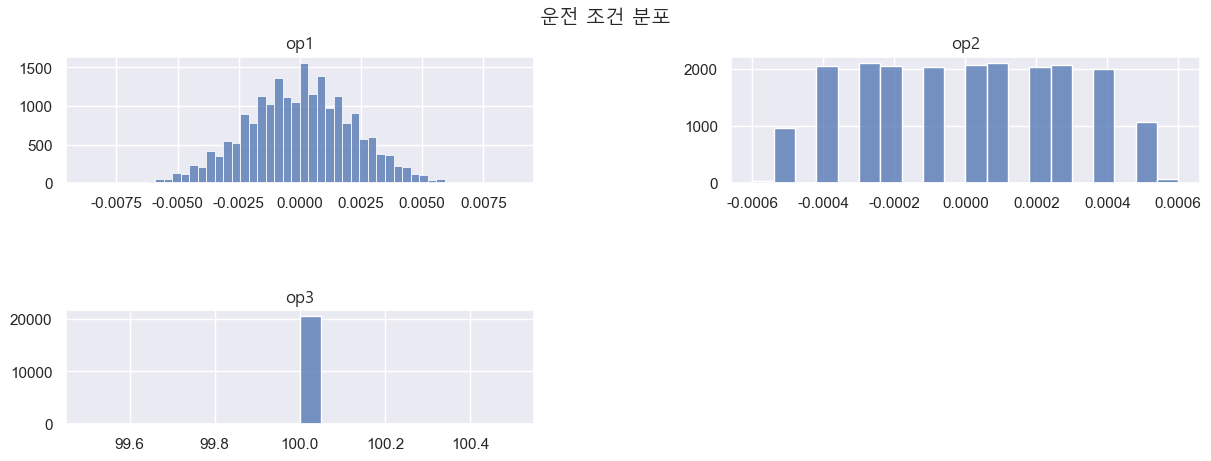

In [12]:
# ...existing code...
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib.font_manager import FontProperties

# 윈도우 한글 폰트 경로
font_path = r"C:\Windows\Fonts\malgun.ttf"

# 폰트 등록 + rcParams 설정
try:
    fm.fontManager.addfont(font_path)            # 폰트 등록
    mpl.rcParams['font.family'] = 'Malgun Gothic'
    mpl.rcParams['font.sans-serif'] = ['Malgun Gothic']
    mpl.rcParams['axes.unicode_minus'] = False
except Exception:
    pass

# FontProperties 객체 (직접 텍스트에 적용용)
fp = FontProperties(fname=font_path)

# op 컬럼명(사용 중인 이름에 맞추어 변경 가능)
op_cols = ['setting_1', 'setting_2', 'setting_3']

sns.set(style="darkgrid")
# constrained_layout 사용 (tight_layout 경고 회피)
fig = plt.figure(figsize=(12, 4.5), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 0.9], hspace=0.35, wspace=0.25)

ax1 = fig.add_subplot(gs[0, 0])   # top-left: op1
ax2 = fig.add_subplot(gs[0, 1])   # top-right: op2
ax3 = fig.add_subplot(gs[1, 0])   # bottom-left: op3
# gs[1,1] intentionally left empty

# op1
sns.histplot(train[op_cols[0]].dropna(), bins=50, ax=ax1)
ax1.set_title('op1', fontproperties=fp)
ax1.set_xlabel('', fontproperties=fp)
ax1.set_ylabel('', fontproperties=fp)

# op2
sns.histplot(train[op_cols[1]].dropna(), bins=20, ax=ax2)
ax2.set_title('op2', fontproperties=fp)
ax2.set_xlabel('', fontproperties=fp)
ax2.set_ylabel('', fontproperties=fp)

# op3
sns.histplot(train[op_cols[2]].dropna(), bins=20, ax=ax3)
ax3.set_title('op3', fontproperties=fp)
ax3.set_xlabel('', fontproperties=fp)
ax3.set_ylabel('', fontproperties=fp)

# 전체 제목 (FontProperties 직접 적용)
fig.suptitle('운전 조건 분포', fontsize=14, fontproperties=fp)

plt.show()
# ...existing code...

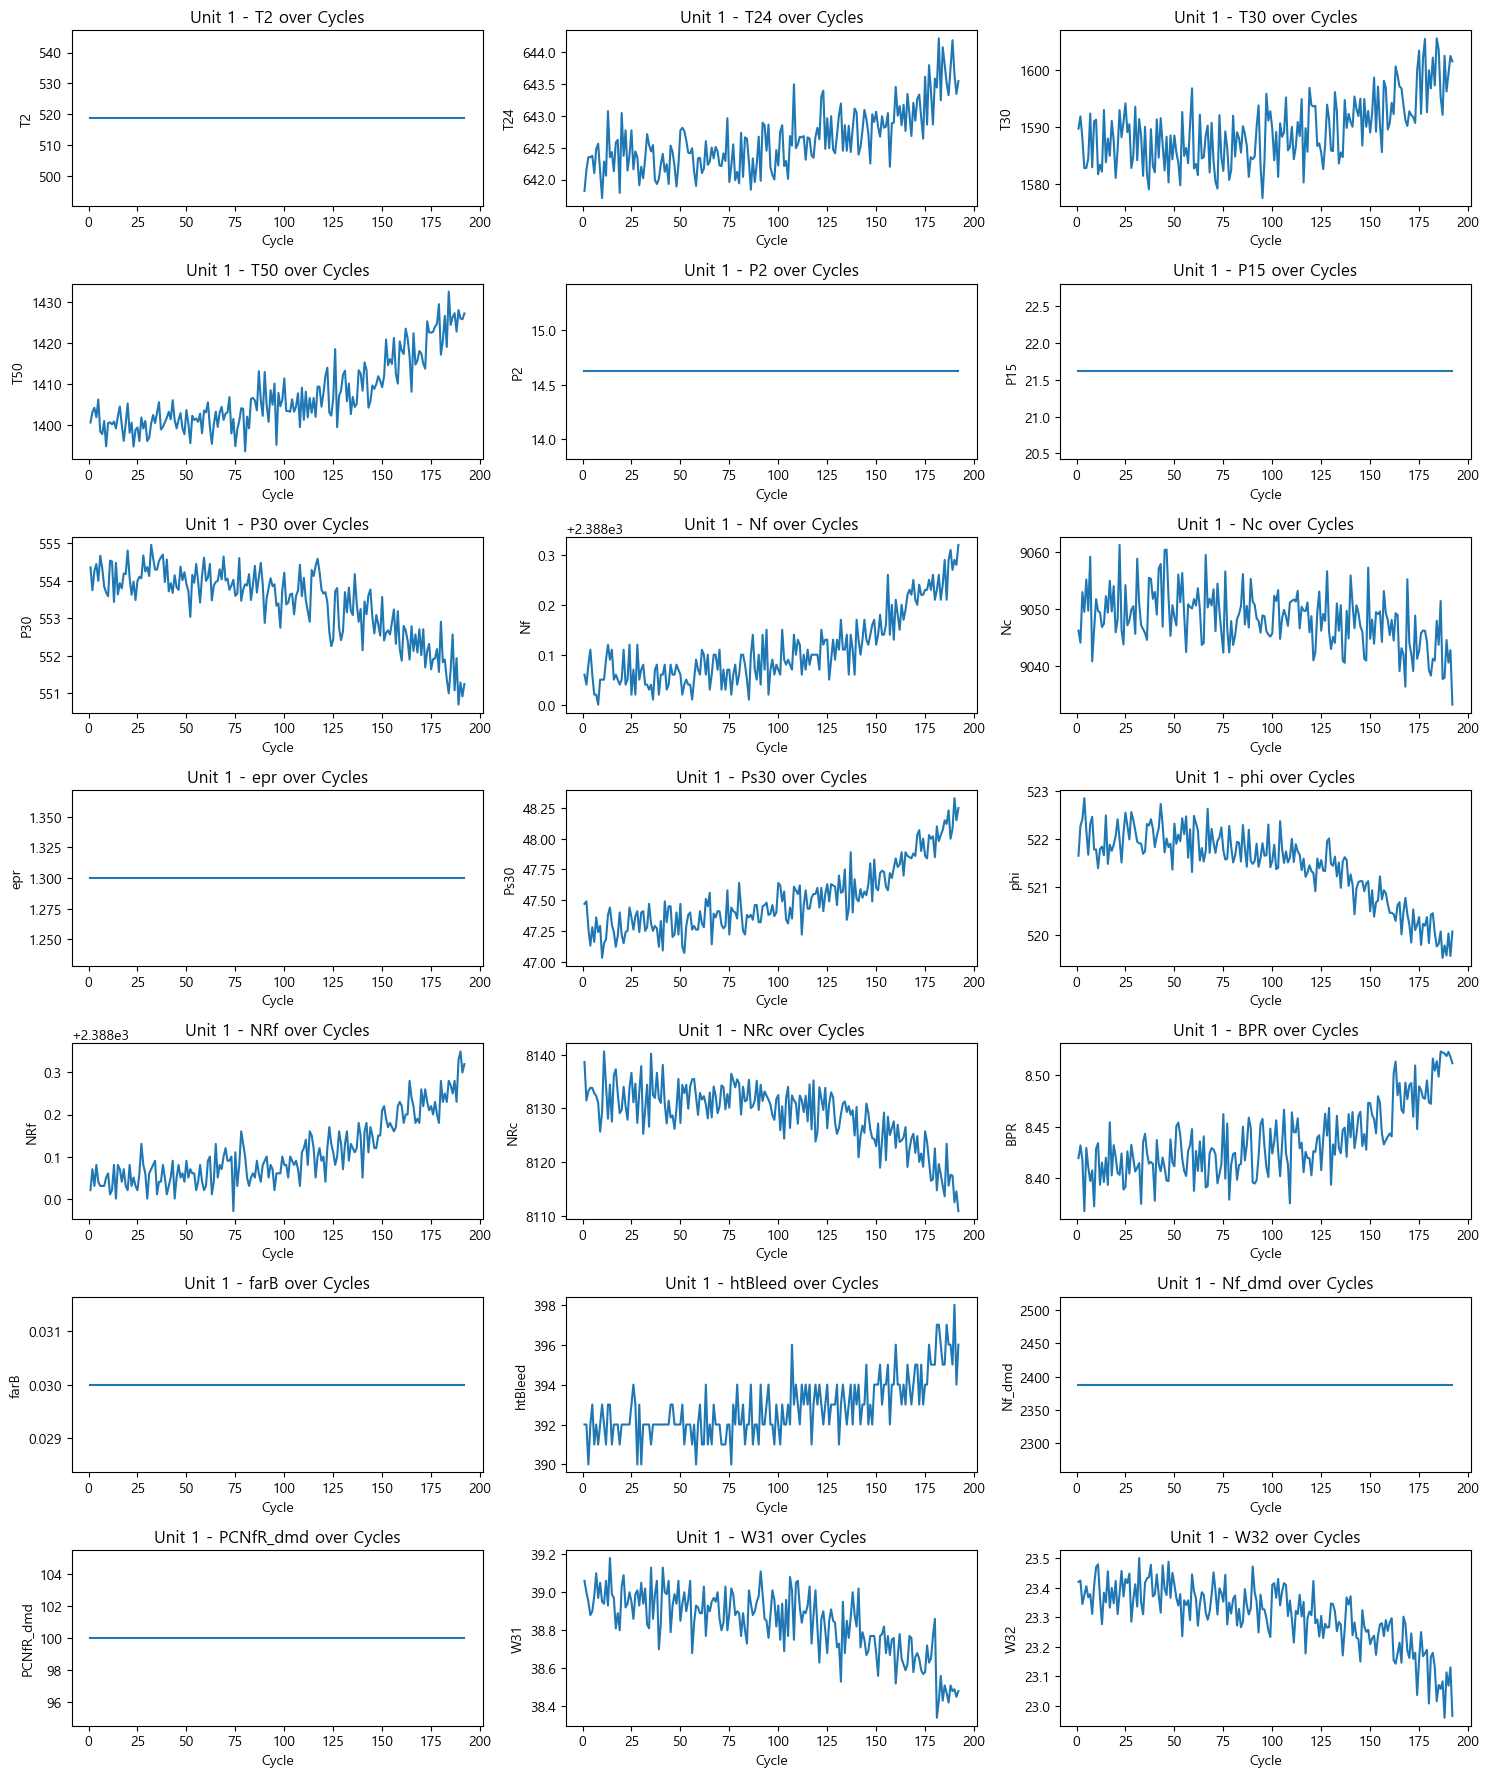

In [6]:
# train 환경조건 분포
unit = train[train['unit'] == 1]

# 각 센서 데이터의 변화
plt.figure(figsize=(15, 20))
for i, sensor in enumerate(col_names[5:]):  # 센서 데이터는 5번째 열부터 시작
    plt.subplot(8, 3, i + 1)
    sns.lineplot(data=unit, x='cycle', y=sensor)
    plt.title(f'Unit 1 - {sensor} over Cycles')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

In [32]:
#  Low-Pass Filter 적용 후 센서 데이터 변화 분석
lpf_train = train.copy()

# Alpha 값 설정 (0.1 ~ 0.3 추천)
ALPHA = 0.1 

for unit in lpf_train['unit'].unique():
    for col in lpf_train.columns[5:-1]:
        # 1. 원본 데이터 가져오기
        raw_data = lpf_train.loc[lpf_train['unit'] == unit, col].values
        
        # 2. 필터링 결과를 담을 리스트
        filtered_values = []
        
        # ★ 핵심 수정사항: 초기값을 0이 아닌 '첫 번째 데이터'로 설정 ★
        prev_val = raw_data[0] 
        
        # 3. 직접 수식 적용 (라이브러리보다 이 방식이 초기값 제어에 유리함)
        for curr_val in raw_data:
            # LPF 공식: (현재값 * alpha) + (이전값 * (1-alpha))
            new_val = (curr_val * ALPHA) + (prev_val * (1 - ALPHA))
            
            filtered_values.append(new_val)
            prev_val = new_val # 다음 턴을 위해 저장
            
        # 4. 결과 덮어쓰기
        lpf_train.loc[lpf_train['unit'] == unit, col] = filtered_values

# 결과 확인 (이제 앞부분이 0으로 안 떨어집니다)
lpf_train.head()

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,...,2388.020000,8138.620000,8.419500,0.03,392.000,2388.0,100.0,39.060000,23.419000,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,641.853000,1589.912000,1400.854000,14.62,...,2388.025000,8137.907000,8.420730,0.03,392.000,2388.0,100.0,39.054000,23.419460,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,641.902700,1589.719800,1401.188600,14.62,...,2388.025500,8137.439300,8.420437,0.03,391.800,2388.0,100.0,39.043600,23.411934,189.0
3,1,4,0.0007,0.0000,100.0,518.67,641.947430,1589.026820,1401.256740,14.62,...,2388.030950,8137.078370,8.415213,0.03,391.820,2388.0,100.0,39.027240,23.408131,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,641.989687,1588.409138,1401.753066,14.62,...,2388.031855,8136.750533,8.416632,0.03,391.938,2388.0,100.0,39.014516,23.407758,187.0


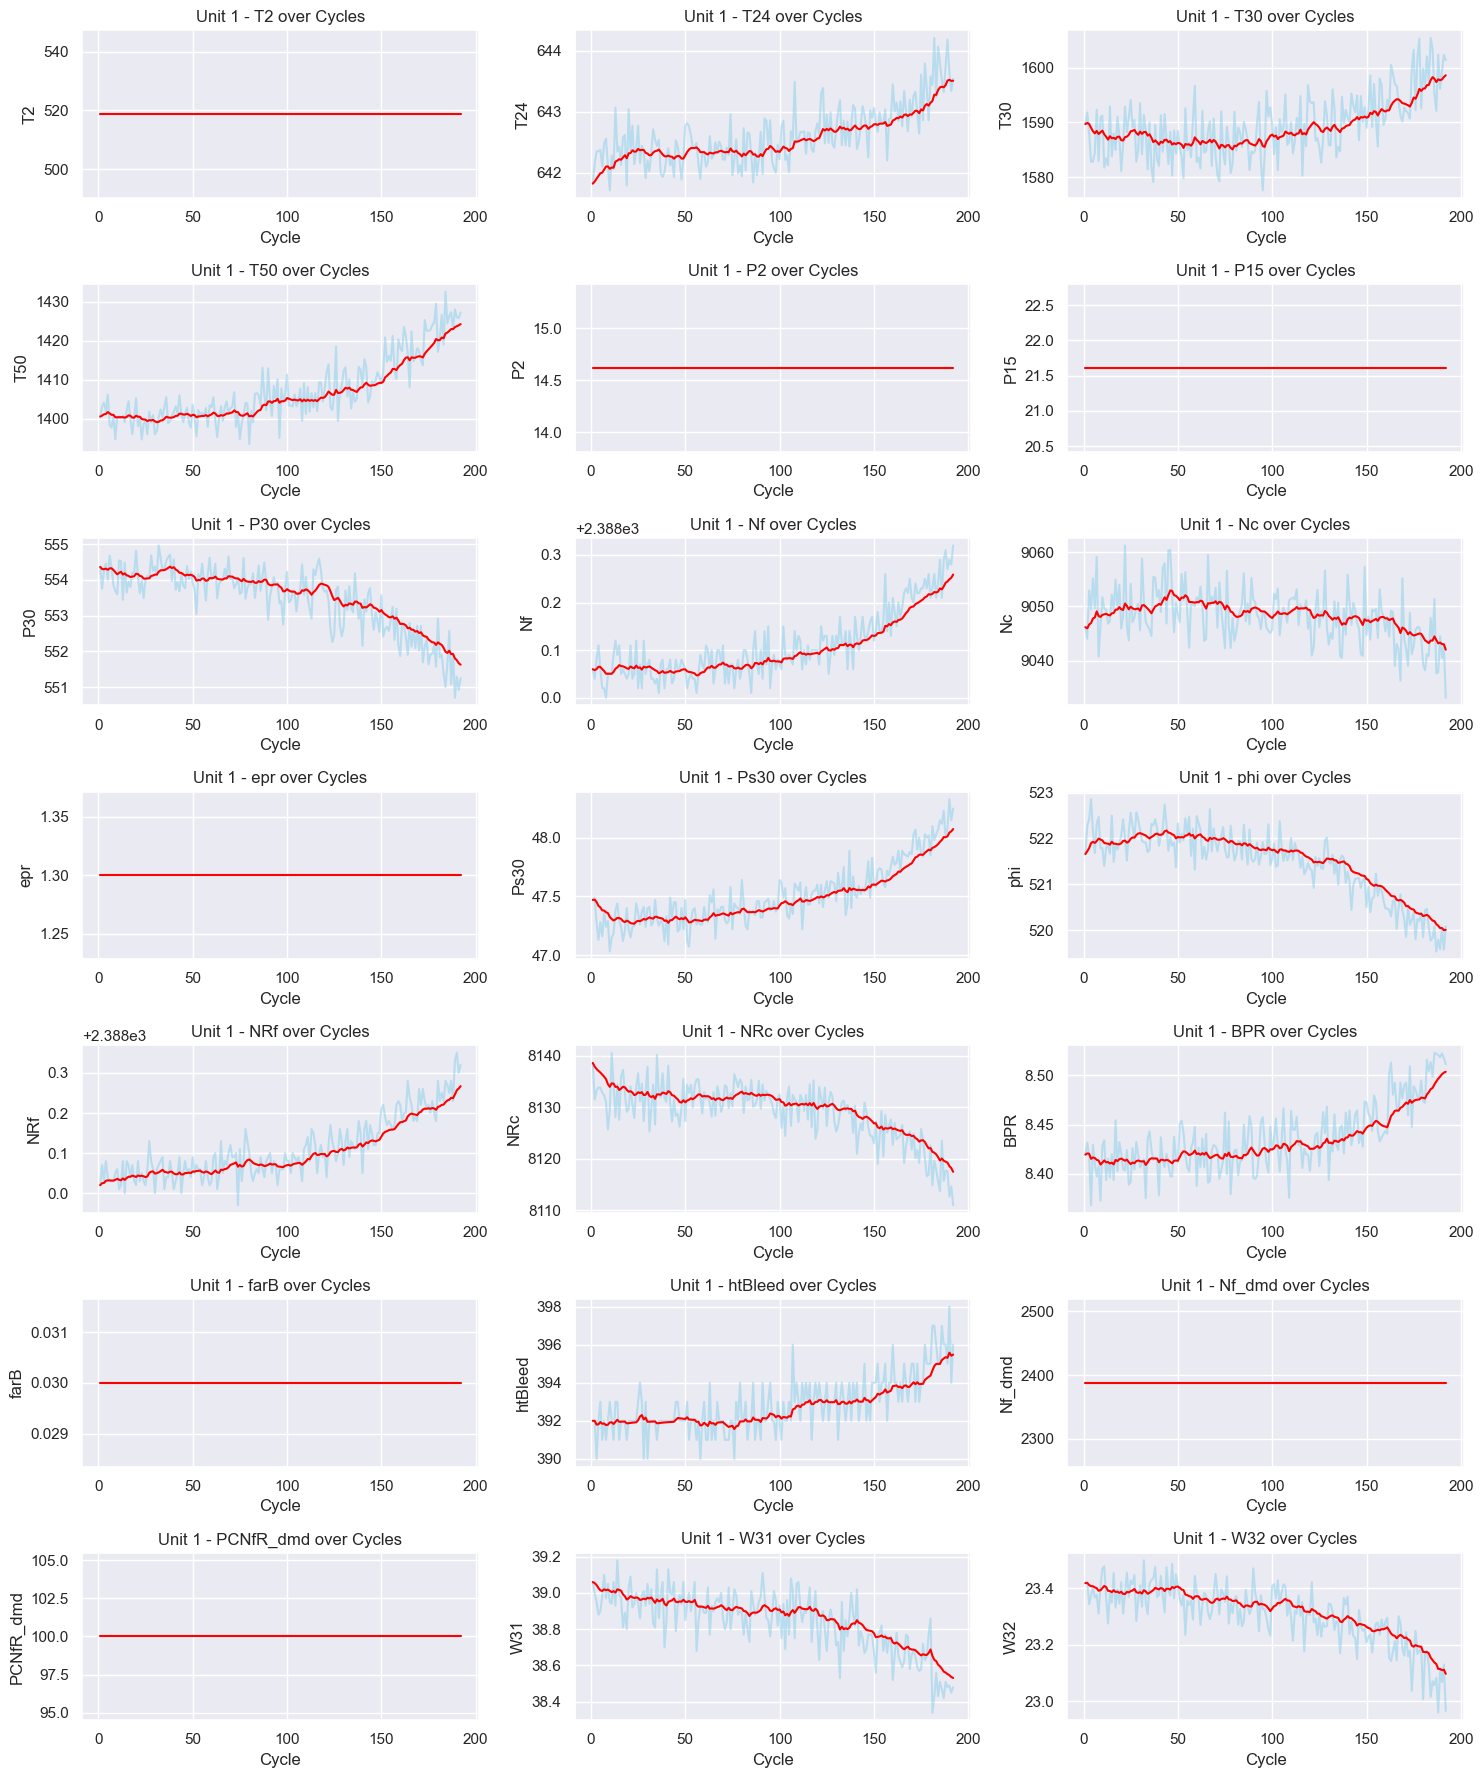

In [24]:
# lpf_train 환경조건 분포
lpf_unit = lpf_train[lpf_train['unit'] == 1]
unit = train[train['unit'] == 1]

# 각 센서 데이터의 변화
plt.figure(figsize=(15, 20))
for i, sensor in enumerate(lpf_train.columns[5:-1]):  # 센서 데이터는 5번째 열부터 시작
    plt.subplot(8, 3, i + 1)
    # 기존 플롯은 연하게 그리기
    # 'unit' 변수가 정수로 덮어써져 있을 수 있으므로, 명확한 DataFrame인 'unit1' 또는 lpf_unit을 사용합니다.
    sns.lineplot(data=unit, x='cycle', y=sensor, color='skyblue', alpha=0.5)
    sns.lineplot(data=lpf_unit, x='cycle', color='red', y=sensor)
    plt.title(f'Unit 1 - {sensor} over Cycles')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

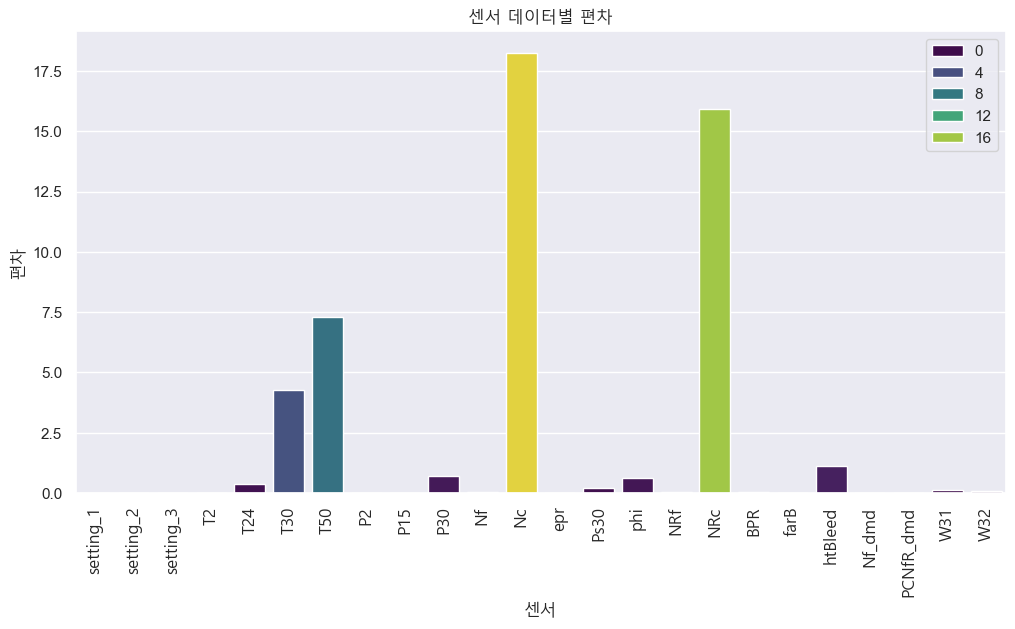

In [36]:
# 편차가 존재하는 컬럼을 찾기
std = lpf_train.iloc[:, 2:-1].std()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=std.index, y=std.values, palette='viridis', hue=std.values)
plt.xticks(rotation=90, fontproperties=fp)
plt.title('센서 데이터별 편차', fontproperties=fp)
plt.legend()
plt.xlabel('센서', fontproperties=fp)
plt.ylabel('편차', fontproperties=fp)
plt.show()

In [85]:
std

setting_1    2.187313e-03
setting_2    2.930621e-04
setting_3    0.000000e+00
T2           6.537152e-11
T24          3.647888e-01
T30          4.284509e+00
T50          7.305883e+00
P2           3.394700e-12
P15          5.976195e-04
P30          7.196992e-01
Nf           5.930087e-02
Nc           1.824439e+01
epr          4.663050e-13
Ps30         2.243401e-01
phi          6.115070e-01
NRf          6.011760e-02
NRc          1.592036e+01
BPR          2.879665e-02
farB         1.556432e-14
htBleed      1.123412e+00
Nf_dmd       0.000000e+00
PCNfR_dmd    0.000000e+00
W31          1.372969e-01
W32          8.238281e-02
dtype: float64

In [86]:
major_features = std[3:][std[3:] > 1e-10].index.to_list()
major_features

['T24',
 'T30',
 'T50',
 'P15',
 'P30',
 'Nf',
 'Nc',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'htBleed',
 'W31',
 'W32']

In [87]:
# 편차가 존재하는 변수 찾기
lpf_train_major = lpf_train[['unit', 'cycle'] + major_features + ['RUL']]
display(lpf_train_major.head())
display(lpf_train_major.shape)

,unit,cycle,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,641.820000,1589.700000,1400.600000,21.61,554.360000,2388.060000,9046.190000,47.470000,521.660000,2388.020000,8138.620000,8.419500,392.000,39.060000,23.419000,191.0
1,1,2,641.853000,1589.912000,1400.854000,21.61,554.299000,2388.058000,9045.978000,47.472000,521.722000,2388.025000,8137.907000,8.420730,392.000,39.054000,23.419460,190.0
2,1,3,641.902700,1589.719800,1401.188600,21.61,554.295100,2388.060200,9046.674200,47.451800,521.791800,2388.025500,8137.439300,8.420437,391.800,39.043600,23.411934,189.0
3,1,4,641.947430,1589.026820,1401.256740,21.61,554.310590,2388.065180,9046.954780,47.419620,521.898620,2388.030950,8137.078370,8.415213,391.820,39.027240,23.408131,188.0
4,1,5,641.989687,1588.409138,1401.753066,21.61,554.279531,2388.064662,9047.774302,47.405658,521.927758,2388.031855,8136.750533,8.416632,391.938,39.014516,23.407758,187.0


(20631, 18)

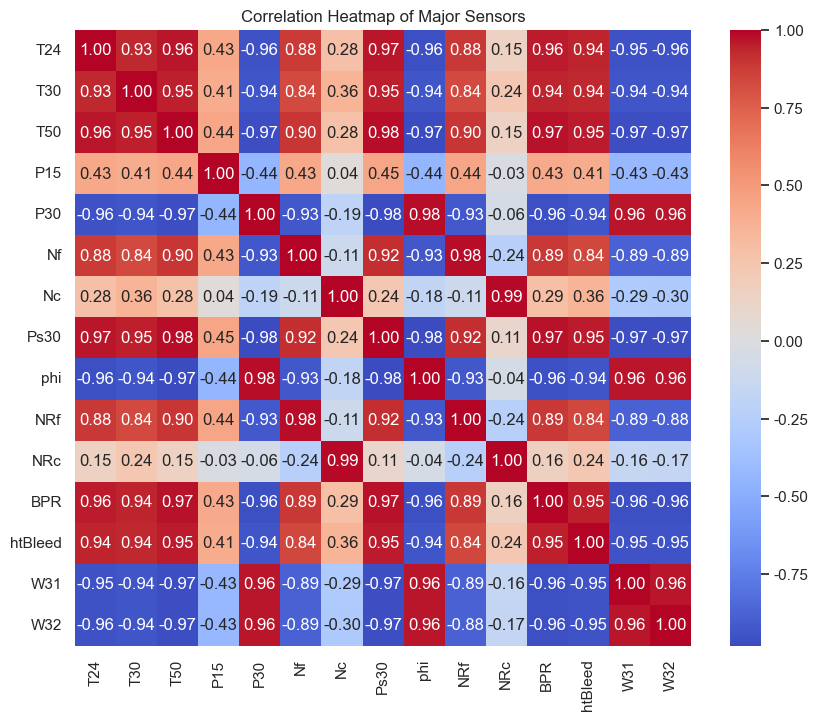

In [88]:
# 센서 데이터의 상관관계 히트맵
corr = lpf_train_major[major_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Major Sensors')
plt.show()

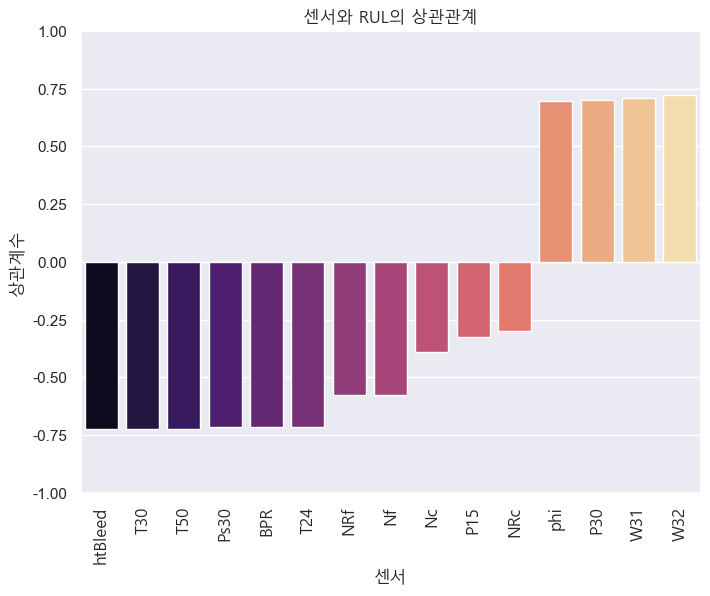

In [89]:
# RUL과의 상관관계 살펴보기
corrwith = lpf_train_major.iloc[:, 2:-1].corrwith(lpf_train_major['RUL']).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=corrwith.index, y=corrwith.values, hue=corrwith.index, palette='magma')
plt.xticks(rotation=90, fontproperties=fp)
plt.ylim(-1, 1)
plt.title('센서와 RUL의 상관관계', fontproperties=fp)
plt.xlabel('센서', fontproperties=fp)
plt.ylabel('상관계수', fontproperties=fp)
plt.show()

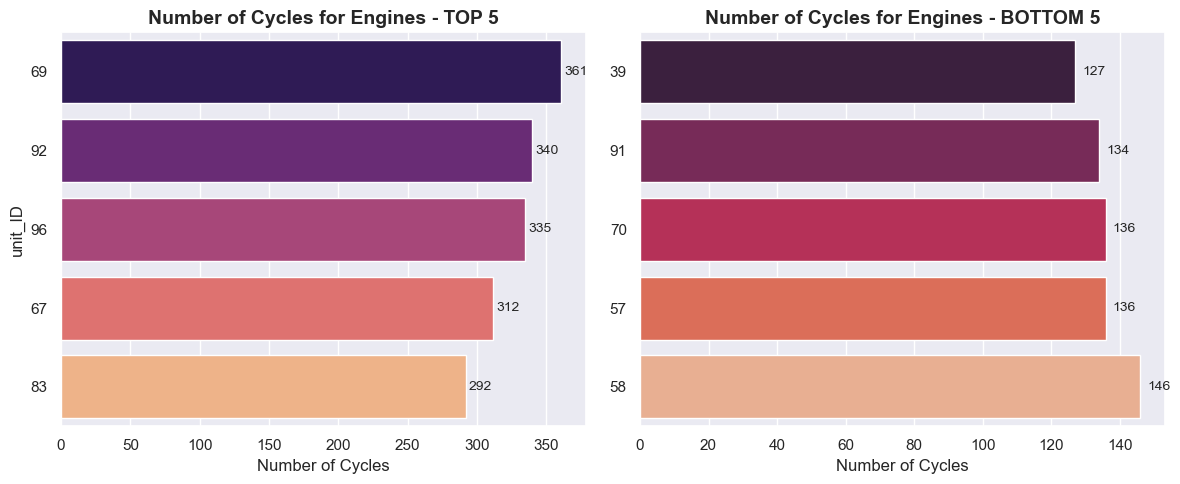

In [90]:
# ...existing code...
# RUL 상위/하위 5 유닛을 한 셀에 나란히 출력
cnt_train_TOP5 = lpf_train_major[['unit', 'RUL']].groupby('unit').max().sort_values(by='RUL', ascending=False).head(5)
cnt_train_BOTTOM5 = lpf_train_major[['unit', 'RUL']].groupby('unit').max().sort_values(by='RUL', ascending=True).head(5)

top_labels = [str(i) for i in cnt_train_TOP5.index]
top_vals = cnt_train_TOP5.RUL.values

bot_labels = [str(i) for i in cnt_train_BOTTOM5.index]
bot_vals = cnt_train_BOTTOM5.RUL.values

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

# Top5 (왼쪽)
sns.barplot(x=top_vals, y=top_labels, ax=axes[0], hue=top_labels, palette='magma')
for i, v in enumerate(top_vals):
    axes[0].text(v + 2, i, str(int(v)), va='center', fontsize=10)
axes[0].set_xlabel('Number of Cycles')
axes[0].set_ylabel('unit_ID')
axes[0].set_title('Number of Cycles for Engines - TOP 5', fontweight='bold', fontsize=14)

# Bottom5 (오른쪽)
sns.barplot(x=bot_vals, y=bot_labels, ax=axes[1], hue=bot_labels, palette='rocket')
for i, v in enumerate(bot_vals):
    axes[1].text(v + 2, i, str(int(v)), va='center', fontsize=10)
axes[1].set_xlabel('Number of Cycles')
axes[1].set_ylabel('')
axes[1].set_title('Number of Cycles for Engines - BOTTOM 5', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()
# ...existing code...

In [91]:
len(major_features)

15

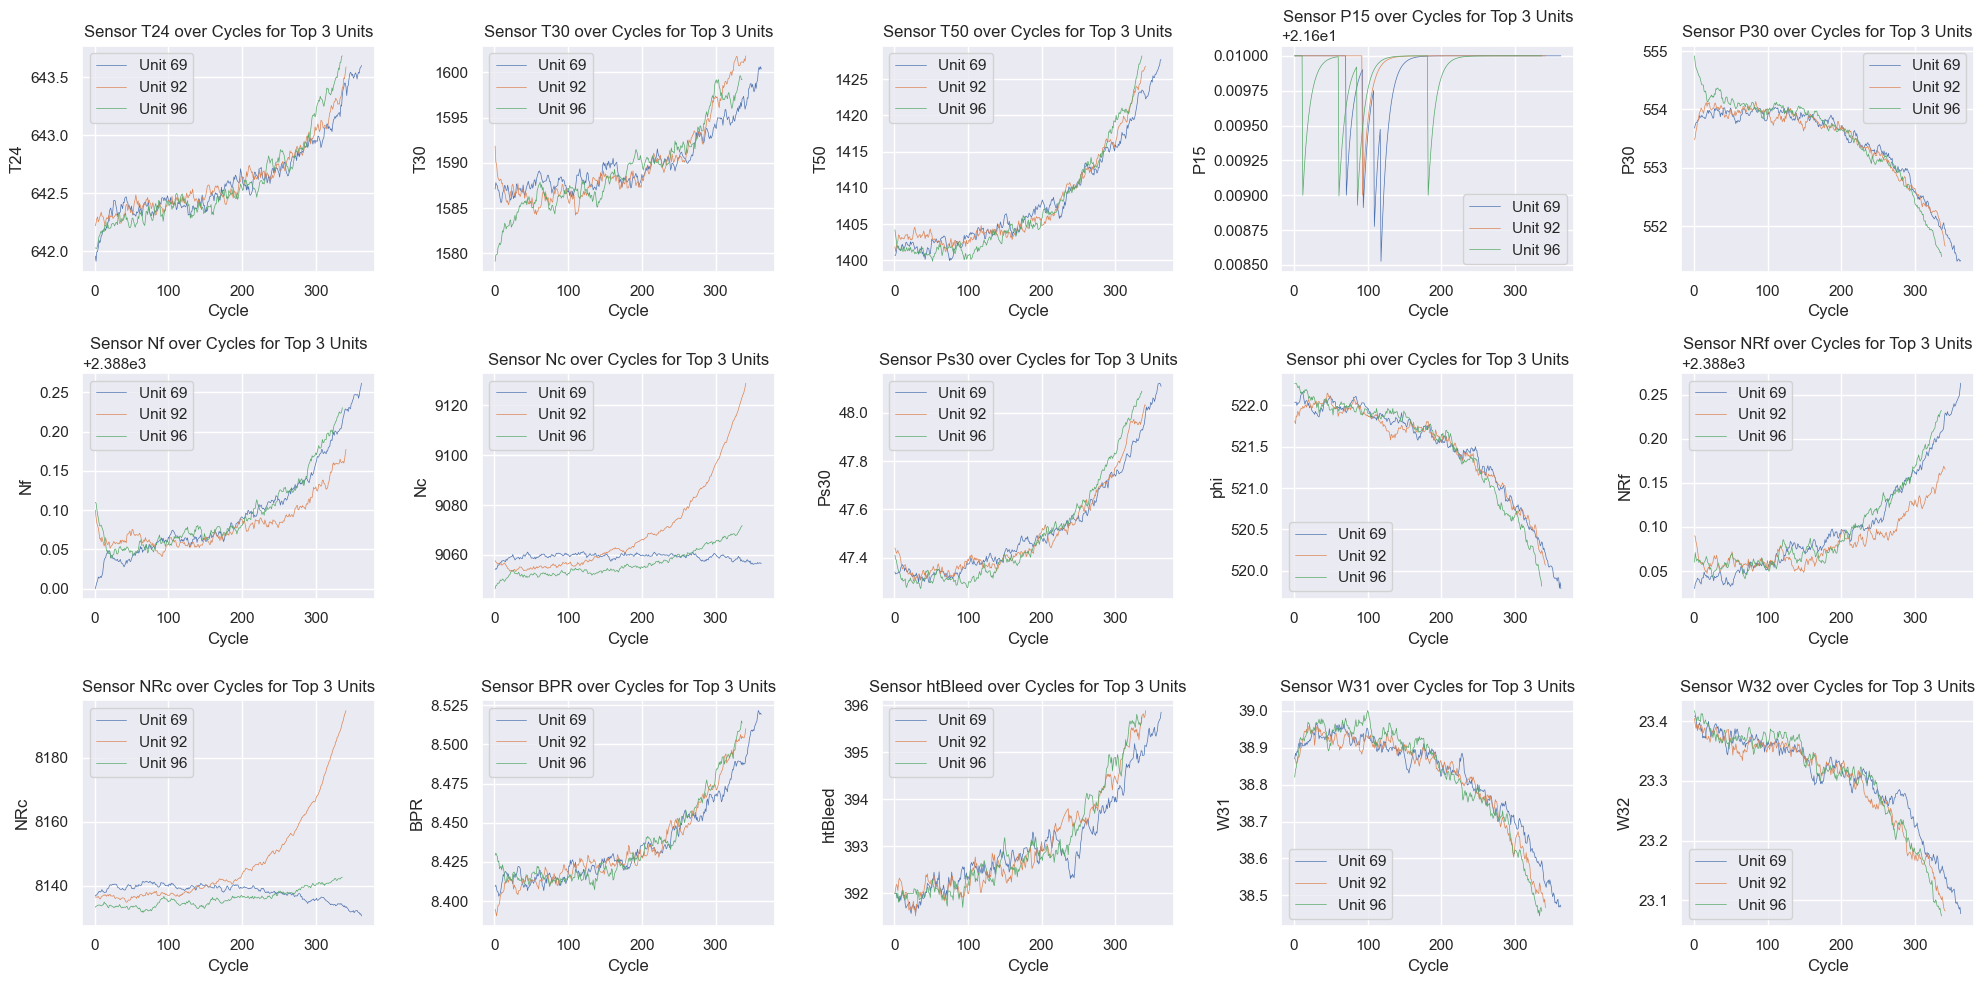

In [92]:
# 상위 3개 유닛의 센서 데이텨 변화 시각화 - 표준 편차 주요 센서들
# 주요 센서들
plt.figure(figsize=(20, 10))
for i, sensor in enumerate(major_features):
    plt.subplot(3, 5, i + 1)
    for unit in cnt_train_TOP5[:3].index:
        unit_data = lpf_train_major[lpf_train_major['unit'] == unit]
        # 선을 더 얇게 그리기
        sns.lineplot(data=unit_data, x='cycle', y=sensor, label=f'Unit {unit}', linewidth=0.5)
    plt.title(f'Sensor {sensor} over Cycles for Top 3 Units')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
    plt.legend()

plt.tight_layout()
plt.show()

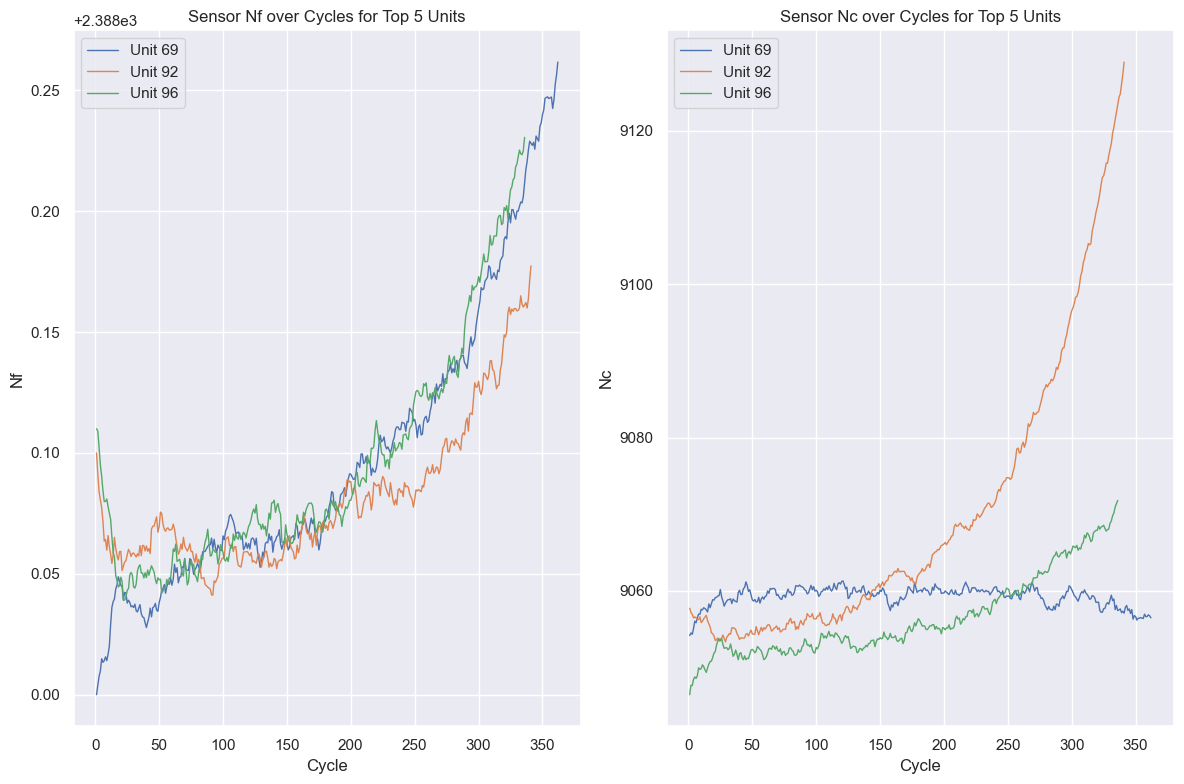

In [93]:
# 하위 3개 유닛의 센서 데이텨 변화 시각화 - 표준 편차 주요 센서들
# 주요 센서들
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(['Nf', 'Nc']):
    plt.subplot(1, 2, i + 1)
    for unit in cnt_train_TOP5[:3].index:
        unit_data = lpf_train_major[lpf_train_major['unit'] == unit]
        # 선을 더 얇게 그리기
        sns.lineplot(data=unit_data, x='cycle', y=sensor, label=f'Unit {unit}', linewidth=1)
    plt.title(f'Sensor {sensor} over Cycles for Top 5 Units')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
    plt.legend()

plt.tight_layout()
plt.show()